In [2]:
%load_ext autoreload
%autoreload 2

import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import boto3
from tqdm.notebook import tqdm
try:
    plt.style.use('rossidata')
except:
    sns.set_style("white")
    
from sklearn.model_selection import KFold,train_test_split,LeaveOneOut,ShuffleSplit
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import sem
import easing
from collections import Counter
from tqdm.notebook import tqdm
from scipy.stats import spearmanr

sys.path.append('../Utility_Scripts/')
from synthetic_data_generator import MLR,meal_income
from ensemble_methods import EnsembleModel

In [3]:
# load ML packages

from sklearn.model_selection import KFold,train_test_split,LeaveOneOut,StratifiedKFold,StratifiedShuffleSplit,GridSearchCV
from sklearn.linear_model import LinearRegression
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr
import shap
from matplotlib.patches import Rectangle as rec
from easing import easing



# Introduction
This is a notebook that walks you through some basic implementations of Ensemble methods for uncertainty quantification and creates all the figures present in [this blogpost](https://www.rossidata.com/UncertaintyQuantificationandEnsembleLearning)


![fig](../media/open_figure_new.png)


# Example Problem for UQ : Individual income vs expendeture on meals

Hypothetically, We asked 1000 people what they spent on their last meal and how much money they make per year. This synthetic data demonstrate heteroscedastic uncertainy as a function of individual income.

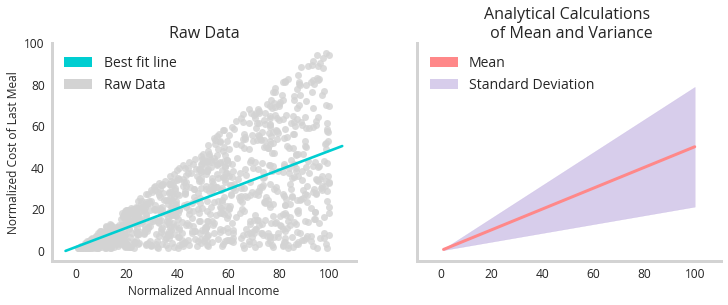

In [4]:
meal_income_dict=meal_income(size=1000)
x_values=meal_income_dict['X']
y_values=meal_income_dict['y']
fig,ax=plt.subplots(1,2,figsize=(12,4),sharex=True,sharey=True)
sns.regplot(x_values.ravel(),y_values.ravel(),ax=ax[0],scatter_kws={'color':'#d3d3d3'},ci=None)


ax[0].set_xlabel('Normalized Annual Income')
ax[0].set_ylabel('Normalized Cost of Last Meal')
ax[0].set_title('Raw Data')
ax[1].set_title('Analytical Calculations \n of Mean and Variance')

mu=meal_income_dict['mu']
sigma=meal_income_dict['sigma']

ax[1].plot(x_values.ravel(), mu,linewidth=3,color='#FF8889')
ax[1].fill_between(x_values.ravel(), mu - sigma, mu + sigma, alpha=0.5,color='#b19cd9')

### adding custom legends
texts = ["Best fit line", "Raw Data"]
colors= ['darkturquoise','#d3d3d3']
recs=[rec((0,0),1,1,fc=color) for color in colors]
ax[0].legend(recs,texts)


texts = ["Mean", "Standard Deviation"]
colors= ['#FF8889','#b19cd9']
alphas=[1,0.5]
recs=[rec((0,0),1,1,fc=color,alpha=alphas[j]) for j,color in enumerate(colors)]
ax[1].legend(recs,texts,loc='upper left')
fig.savefig('figures/meal_expenses.png',bbox_inches='tight')

# Example Ensemble Method 5 fold split : Linear Model

Our first attempt to quantify the uncertainty of the data above uses a linear model

In [5]:
class Linear_Uncertainty_Predictor():
    def __init__(self,X_data,y_data):
        self.X_train =X_data
        self.y_train = y_data
        
    def train_models(self,n_splits=5,kernal='linear'):
        '''Function for training models 
        Inputs:
        X_dataset: Inputs of the training data (MxN)
        y_dataset: Outputs of the trainig data (1xN)
        params: the parameters of the LGBM model
        n_split: the number of splits to be used to creat int(n_splits) seperate models

        Returns:
        models: int(n_splits) number of independent models trained on the folds of the data
        '''

        ss = ShuffleSplit(test_size=1/n_splits,n_splits=n_splits,random_state=42)

        models=[]
        coeffs=[]
        for train_index, test_index in ss.split(self.X_train):
            X_train, X_val =self.X_train[train_index,:], self.X_train[test_index,:], 
            y_train, y_val =self.y_train[train_index], self.y_train[test_index]
            reg = LinearRegression(fit_intercept=False).fit(X_train, y_train)
            
            models.append(reg)
            coeffs.append(reg.coef_[0][0])
        self.models=models
        self.coefficients=coeffs
        
    def predict(self,X):
        predictions=[]
        for model in self.models:
            predictions.append(model.predict(X))
        
        # Values chosen by median committe
        ensemble_predictions =np.mean(np.stack(predictions, axis=0) ,axis=0)
        ensemble_uncertainty=np.std(np.stack(predictions, axis=0) ,axis=0)
        self.predictions={'prediction':ensemble_predictions,'uncertainty':ensemble_uncertainty}
        self.raw_predictions={'X':np.squeeze(np.stack(predictions, axis=0))}
        
        return self.predictions

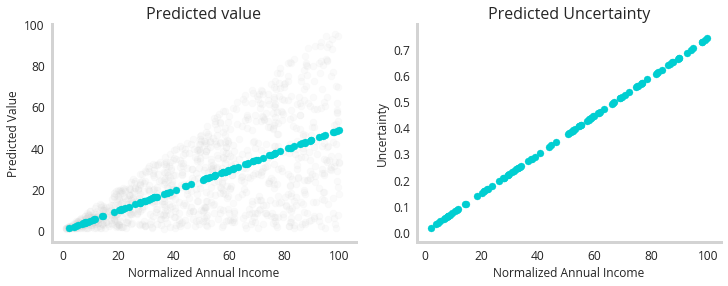

In [6]:
X_dataset, X_holdout, y_dataset, y_holdout = train_test_split(x_values, y_values, test_size=0.1,random_state=42)
Predictor=Linear_Uncertainty_Predictor(X_dataset,y_dataset)
Predictor.train_models(n_splits=5)

prediction_dict=Predictor.predict(X_holdout)


fig,ax=plt.subplots(1,2,figsize=(12,4))
ax[0].scatter(x_values.ravel(),y_values.ravel(),color='#d3d3d3',alpha=0.1)

ax[0].scatter(X_holdout,prediction_dict['prediction'])
# ax[0].plot([0,100],[0,100],color='#d3d3d3')
#ax[1].set_ylim([0,0.05])
# ax[0].fill_between(x_values.ravel(), mu - sigma, mu + sigma, alpha=0.5,color='#d3d3d3')

ax[1].scatter(X_holdout,prediction_dict['uncertainty'])
ax[1].set_xlabel('Normalized Annual Income')
ax[1].set_ylabel('Uncertainty')
ax[1].set_title('Predicted Uncertainty')
ax[0].set_title('Predicted value')

ax[0].set_xlabel('Normalized Annual Income')
ax[0].set_ylabel('Predicted Value')
fig.savefig('figures/linear_model_summary.png',dpi=300,bbox_inches='tight')

# Examples: Large Ensembles with LGBM

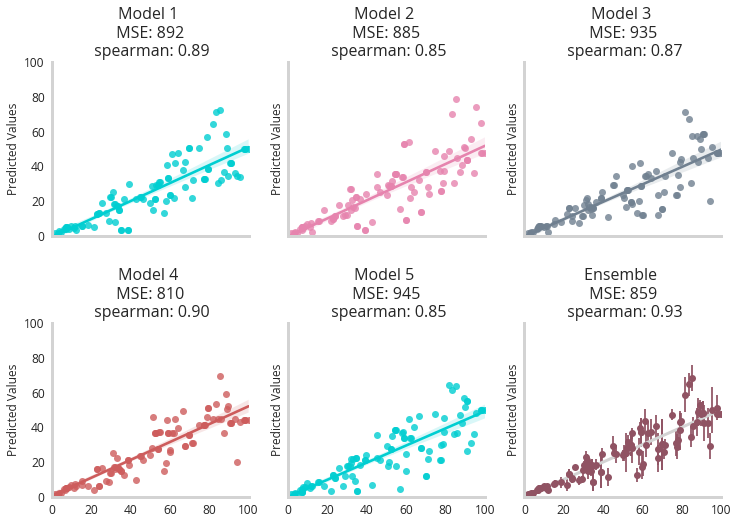

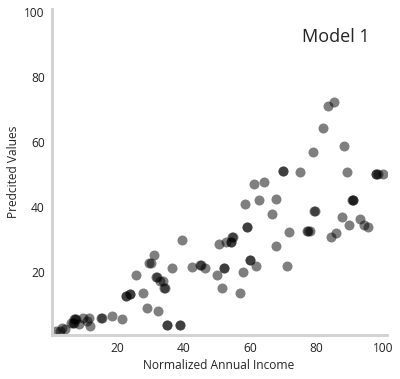

In [84]:
X_dataset, X_holdout, y_dataset, y_holdout = train_test_split(x_values, y_values, test_size=0.1,random_state=42)

LGBM_model=EnsembleModel(X_dataset,y_dataset)
LGBM_model.train_models(n_splits=5,kernal='LGB',splitting='kfold')
LGBM_model.predict(X_holdout)
LGBM_model.visualize_ensemble(X_holdout,destination='figures',title='LGBM',animate=True)




# Multi-feature synthetic data. 
Included in this package we have some helper functios for creating multiple feature heteroskedastic noise profiles. Here is just an example of that generating uncertain data for multiple linear regression.



All Coefficients [2.367920490619232, 1.215037959213436, 1.2325267828696271, 0.49877330775911355, -0.023693915636459284, 0.41816331346315516, 0.07682460291161497, -1.4334394017803826, 1.2395582513320196, 1.2406105226865072]


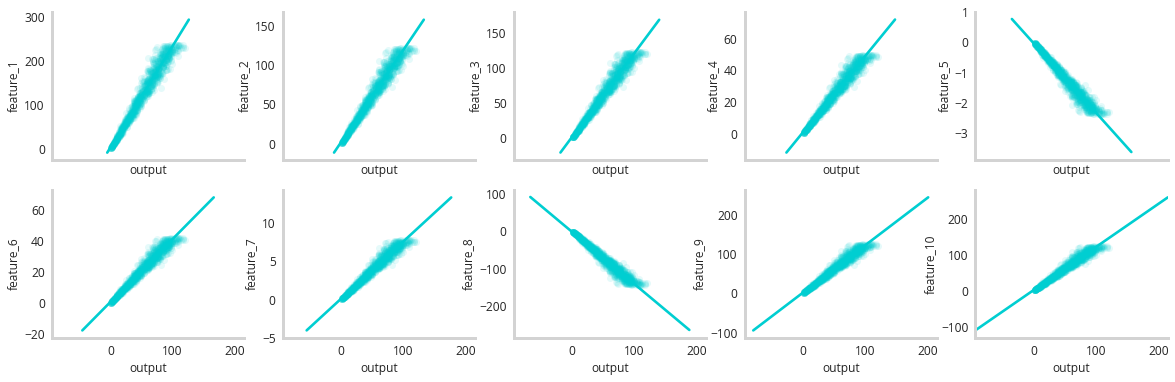

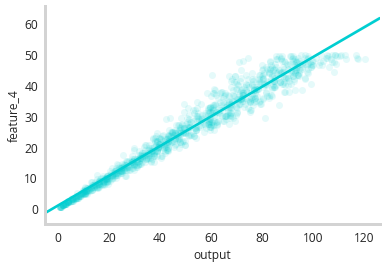

In [10]:
from synthetic_data_generator import MLR
all_data, X,y,ngroups=MLR()
x_features=list(X.columns)
fig,ax=plt.subplots(2,5,figsize=(20,6),sharex=True)
axs=ax.ravel()
for l,x_feature in enumerate(x_features):
    sns.regplot(all_data.output,all_data[x_feature],ax=axs[l],color='darkturquoise',scatter_kws={'alpha':0.1})
    
fig,ax=plt.subplots()

sns.regplot(all_data.output,all_data['feature_4'],ax=ax,color='darkturquoise',scatter_kws={'alpha':0.1})
    

# Load Boston housing dataset // playing with stratification

In [16]:
from sklearn.datasets import load_boston
X_boston, y_boston = load_boston(return_X_y=True)

In [3]:
# create stratified holdout set


def continuous_stratification(y,n_bins,test_size=0.1):
    '''Function that returns the stratified indexes of a continously valued y'''
    bins=np.linspace(min(y), max(y),n_bins)
    digitized_y=np.digitize(y,bins)
    index_list=np.arange(len(y))
    stratified_indexes=[]

    n_samples=int(len(y)*test_size)
    bucket_list=list(set(digitized_y))
    n_samples_per_bucket=int(n_samples/len(bucket_list))

    for bucket in list(set(digitized_y)):
        sub_index_list=index_list[digitized_y==bucket]
        sample_indexes=np.random.choice(sub_index_list,size=n_samples_per_bucket,replace=False)
        stratified_indexes+=list(sample_indexes)
    # returns test and train indexes
    return np.array(stratified_indexes),np.setdiff1d(index_list,stratified_indexes)



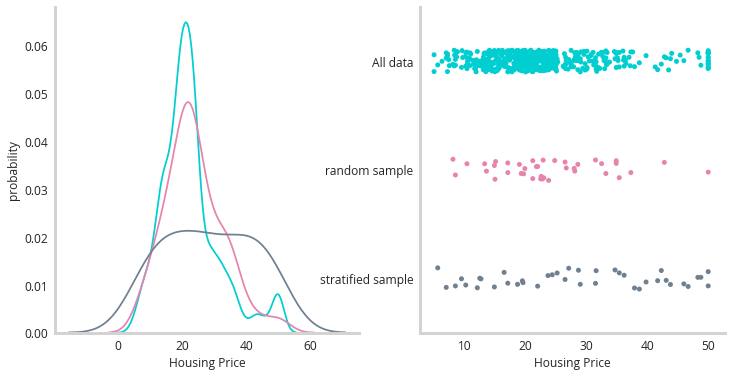

In [24]:


test,train=continuous_stratification(y,20,test_size=.1)
random_sample=np.random.choice(y,size=len(test))

# X_holdout,y_holdout=X[test,:],y[test]


fig,ax=plt.subplots(1,2,figsize=(12,6))
sns.distplot(y,hist=False,ax=ax[0],label='All data')
sns.distplot(random_sample,hist=False,ax=ax[0],label='random sample')

sns.distplot(y[test],hist=False,ax=ax[0],label='stratified sample')


complete=pd.DataFrame({'price':y,'label':'All data'})
stratified=pd.DataFrame({'price':y[test],'label':'stratified sample'})
random=pd.DataFrame({'price':random_sample,'label':'random sample'})
meta_data=pd.concat([complete,random,stratified])

sns.stripplot(x='price',y='label',data=meta_data,ax=ax[1])
ax[0].legend('')
ax[0].set_ylabel('probability')
ax[0].set_xlabel('Housing Price')
ax[1].set_xlabel('Housing Price')
ax[1].set_ylabel('')
fig.savefig('figures/sampling_figure.png',bbox_inches='tight')

In [72]:
# playing with stratification
X_dataset, X_holdout, y_dataset, y_holdout = train_test_split(X_boston, y_boston, test_size=0.1, random_state=88)


nsplits=10

shuffle_model = EnsembleModel(X_dataset, y_dataset)
shuffle_model.train_models(n_splits=nsplits, kernal='LGB',splitting='shuffle')
shuffle_predicted_dict=shuffle_model.predict(X_holdout)

kfold_model = EnsembleModel(X_dataset, y_dataset)
kfold_model.train_models(n_splits=nsplits, kernal='LGB',splitting='kfold')
kfold_predicted_dict=kfold_model.predict(X_holdout)

stratified_model = EnsembleModel(X_dataset, y_dataset)
stratified_model.train_models(n_splits=nsplits, kernal='LGB',splitting='stratified')
stratified_predicted_dict=stratified_model.predict(X_holdout)

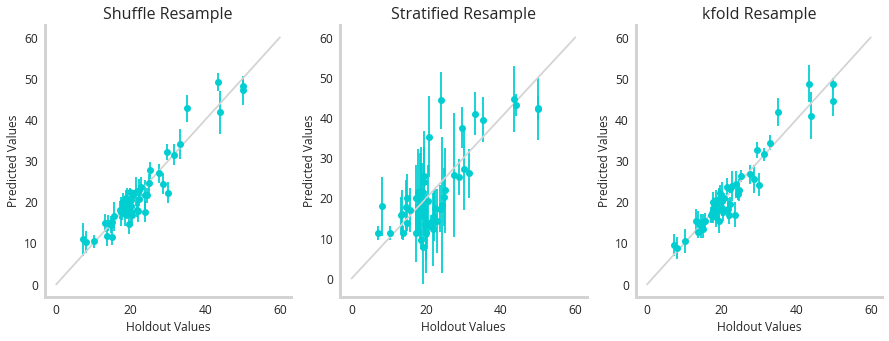

In [81]:

fig,ax=plt.subplots(1,3,figsize=(15,5))
ax[0].errorbar(y_holdout,shuffle_predicted_dict['prediction'],yerr=shuffle_predicted_dict['uncertainty'],fmt='o')
ax[0].plot([0,60],[0,60],color='#d3d3d3')
ax[0].set_xlabel('Holdout Values')
ax[0].set_ylabel('Predicted Values')
ax[0].set_title('Shuffle Resample')


ax[1].errorbar(y_holdout,stratified_predicted_dict['prediction'],yerr=stratified_predicted_dict['uncertainty'],fmt='o')
ax[1].plot([0,60],[0,60],color='#d3d3d3')
ax[1].set_xlabel('Holdout Values')
ax[1].set_ylabel('Predicted Values')
ax[1].set_title('Stratified Resample')



ax[2].errorbar(y_holdout,kfold_predicted_dict['prediction'],yerr=kfold_predicted_dict['uncertainty'],fmt='o')
ax[2].plot([0,60],[0,60],color='#d3d3d3')
ax[2].set_xlabel('Holdout Values')
ax[2].set_ylabel('Predicted Values')
ax[2].set_title('kfold Resample')
fig.savefig('figures/multi_sample_predict.png',bbox_inches='tight')



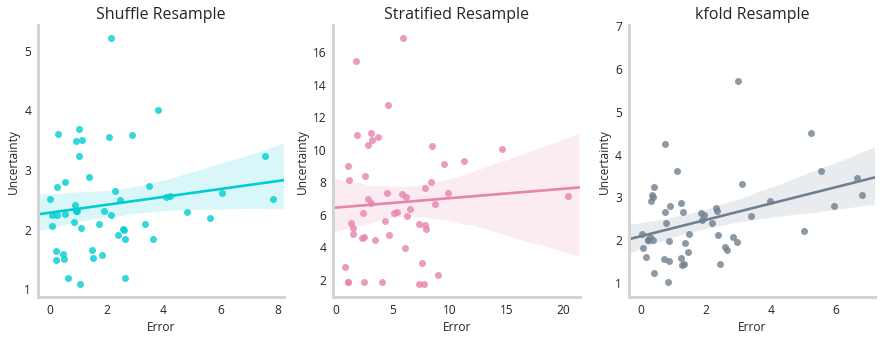

In [80]:
#error plots
fig,ax=plt.subplots(1,3,figsize=(15,5))

sns.regplot(abs(y_holdout-shuffle_predicted_dict['prediction']),shuffle_predicted_dict['uncertainty'],ax=ax[0])

sns.regplot(abs(y_holdout-stratified_predicted_dict['prediction']),stratified_predicted_dict['uncertainty'],ax=ax[1])

sns.regplot(abs(y_holdout-kfold_predicted_dict['prediction']),kfold_predicted_dict['uncertainty'],ax=ax[2])
ax[0].set_xlabel('Error')
ax[0].set_ylabel('Uncertainty')
ax[0].set_title('Shuffle Resample')

ax[1].set_xlabel('Error')
ax[1].set_ylabel('Uncertainty')
ax[1].set_title('Stratified Resample')

ax[2].set_xlabel('Error')
ax[2].set_ylabel('Uncertainty')
ax[2].set_title('kfold Resample')
fig.savefig('figures/multi_sample_error.png',bbox_inches='tight')

In [14]:
def train_models(X_dataset,y_dataset,n_splits=5):
    '''Function for training models 
    Inputs:
    X_dataset: Inputs of the training data (MxN)
    y_dataset: Outputs of the trainig data (1xN)
    params: the parameters of the LGBM model
    n_split: the number of splits to be used to creat int(n_splits) seperate models
    
    Returns:
    models: int(n_splits) number of independent models trained on the folds of the data
    '''

    
    kf = KFold(n_splits=n_splits)

    models=[]

    for train_index, test_index in kf.split(X_dataset):
        X_train, X_val, y_train, y_val = X_dataset[train_index,:], X_dataset[test_index,:], y_dataset[train_index], y_dataset[test_index]
        reg = LinearRegression().fit(X_train, y_train)

        models.append(reg)
    return models

class ensemble_model():
    '''This class is '''
    def __init__(self,models):
        self.models=models
        
    def predict(self,X):
        predictions=[]
        for model in self.models:
            predictions.append(model.predict(X))
        
        # Values chosen by median committe
        ensemble_predictions =np.median(np.stack(predictions, axis=0) ,axis=0)
        ensemble_uncertainty=np.std(np.stack(predictions, axis=0) ,axis=0)
        
        return {'prediction':ensemble_predictions,'uncertainty':ensemble_uncertainty}

# Quantifying Volatility in the number of member models
How many models should you actually pick? Well simply put the best way to do this is to sweep the space and look for bifurcations in performance.

In [32]:
# volatility as a function of splitting

meal_income_dict = meal_income(size=10000)
x_values = meal_income_dict['X']
y_values = meal_income_dict['y']

X_dataset, X_holdout, y_dataset, y_holdout = train_test_split(x_values, y_values, test_size=0.1, random_state=42)

    
MSE=[]
uncertainty=[]
k_values=np.arange(2,20)
uncertainty_dict={}
error=[]
error_uncertainty_corr={}
error_dict={}
for k in tqdm(k_values):
    LGBM_model = EnsembleModel(X_dataset, y_dataset)
    LGBM_model.train_models(n_splits=k, kernal='LGB',splitting='kfold')
    LGBM_model.predict(X_holdout)
    
    
    

    predicted_vals =LGBM_model.predictions['prediction']

    MSE.append(mean_squared_error(y_holdout,predicted_vals))
    
    uncertainty_vals =LGBM_model.predictions['uncertainty']
    
    error_vals=abs(y_holdout.ravel()-predicted_vals.ravel())
    uncertainty_dict[str(k)]=uncertainty_vals
    
    uncertainty.append(uncertainty_vals)
    error.append(error_vals)
    error_dict[str(k)]=error_vals
    error.append(abs(y_holdout-predicted_vals).ravel())
    error_uncertainty_corr[str(k)]=spearmanr(error_vals,uncertainty_vals)[0]
    

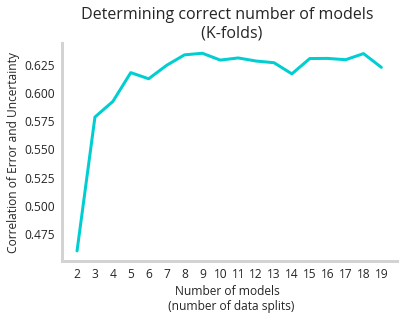

In [50]:
fig,ax=plt.subplots()



ax.plot(error_uncertainty_corr.keys(),error_uncertainty_corr.values(),linewidth=3)

ax.set_xlabel('Number of models \n (number of data splits)')
ax.set_ylabel('Correlation of Error and Uncertainty')
ax.set_title('Determining correct number of models \n (K-folds)')
fig.savefig('figures/model_determinatino.png',dpi=300,bbox_inches='tight')